# Sagemaker Implementation of LDA
# Topic Modeling of CPD Allegations

### Data preprocessing

In [ ]:
!conda install -y scipy
!pip install mxnet

In [68]:
from sklearn.feature_extraction import text
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from pprint import pprint
import preprocessing as p
import pandas as pd
import seaborn as sns
import numpy as np
import nltk
import re

%load_ext autoreload
%autoreload 2

# download any necessary nltk packages
nltk.download('punkt')
nltk.download('stopwords')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Import csv
csv_url = "https://raw.githubusercontent.com/andresnigenda/cpd_complaints_nlp/andres/narratives.csv"
df = p.prepare_data(csv_url)

There are 19966 complaints
There are 17001 unique complaints
(17001, 2)


In [4]:
# Define additional stopwords
additional_stopwords = set(["accused", "reporting", "party", "alleges", "officer", 
                        "alleged", "alleges", "complainant", "officers", "victim", 
                        "police", "stated", "report", "states", "called", 
                        "did", "told", "provide", "incident", "regarding", "issued",
                        "reported", "vehicle", "car", "justification",
                        "district", "uniformed", "threatened", "witness", "th",
                        "number", "scene", "chicago"]).union(text.ENGLISH_STOP_WORDS)

# Call the preprocessing class and stem data
stemmed_data = p.PreProcess(df, additional_stopwords, True)
stemmed_data._fit_vectorizer()
vocabulary = stemmed_data.vectorizer.get_feature_names()
len_vocab = len(vocabulary)

### Sagemaker

Steps:

1. Convert the term-count allegation vectors into numpy arrays, break into training and validation and then convert into recordio format
2. Upload the training and validation data to S3
5. Use the LDA training image from SageMaker and kick off a hyperparameter tuning job
6. Inspect the topics learned by the training job

Sources: 
- LDA: https://nbviewer.jupyter.org/github/awslabs/amazon-sagemaker-examples/blob/master/scientific_details_of_algorithms/lda_topic_modeling/LDA-Science.ipynb
- LDA: https://docs.aws.amazon.com/sagemaker/latest/dg/lda-how-it-works.html
- Hyperparameters: https://docs.aws.amazon.com/sagemaker/latest/dg/lda_hyperparameters.html
- Tuning 1: https://sagemaker.readthedocs.io/en/stable/overview.html#sagemaker-automatic-model-tuning
- Tuning 2: https://docs.aws.amazon.com/sagemaker/latest/dg/lda-tuning.html
- Best model: https://github.com/awslabs/amazon-sagemaker-examples/blob/master/hyperparameter_tuning/analyze_results/HPO_Analyze_TuningJob_Results.ipynb
- Other useful examples: https://alexandersimes.com/unsupervised/machine/learning/nlp/sagemaker/2019/09/01/got.html

*Setup*

In [5]:
# Imports
from botocore.exceptions import ClientError
import mxnet as mx
import os, re
import boto3
import tarfile

# accessing the SageMaker Python SDK
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.amazon.common import numpy_to_record_serializer
from sagemaker.predictor import csv_serializer, json_deserializer
from sagemaker.tuner import HyperparameterTuner, ContinuousParameter, IntegerParameter, CategoricalParameter

In [6]:
# Get role and define basic s3 parameters
# Note: this notebook was ran on an aws ml instance on Sagemaker
role = get_execution_role()
bucket = 'ml-allegations'
prefix = 'sagemaker/'
region_name = 'us-east-1'

In [7]:
# Split data into training and validation (test) and upload to S3

# split into training and validation and convert to appropriate format
np_data = stemmed_data.doc_term_matrix.toarray()
n_allegations = np_data.shape[0]
indices = np.random.permutation(n_allegations)
# 80/20 split
split_idx = round(np_data.shape[0] * 0.80)
training_idx, validation_idx = indices[:split_idx], indices[split_idx:]
training, validation = np_data[training_idx,:], np_data[validation_idx,:]
n_training = training.shape[0]
n_validation = validation.shape[0]
# convert vectors to Protobuf RecordIO format
recordio_protobuf_serializer = numpy_to_record_serializer()
recordio_training = recordio_protobuf_serializer(training)
recordio_validation = recordio_protobuf_serializer(validation)

# S3 upload
training_file_name = 'lda_training.data'
validation_file_name = 'lda_validation.data'
s3_training_object = os.path.join(prefix, 'train', training_file_name)
s3_validation_object = os.path.join(prefix, 'validation', validation_file_name)

try:
    s3_client = boto3.client(
        "s3",
        region_name=region_name
    )
    s3_client.upload_fileobj(recordio_training, bucket, s3_training_object)
    s3_client.upload_fileobj(recordio_validation, bucket, s3_validation_object)
    s3_train_data = 's3://{}/{}'.format(bucket, s3_training_object)
    s3_validation_data = 's3://{}/{}'.format(bucket, s3_validation_object)
    print('Uploaded to s3: ', s3_train_data)
    print('Uploaded to s3: ', s3_validation_data)
except ClientError as e:
    print('boto3 error: ', e)
except Exception as e:
    print('Unexpected exception: ', e)

Uploaded to s3:  s3://ml-allegations/sagemaker/train/lda_training.data
Uploaded to s3:  s3://ml-allegations/sagemaker/validation/lda_validation.data


In [8]:
# Save data to csv for inference for safety
np.savetxt("training.csv", training, delimiter=",")
np.savetxt("training_idx.csv", training_idx, delimiter=",")
np.savetxt("testing.csv", validation, delimiter=",")
np.savetxt("testing_idx.csv", validation_idx, delimiter=",")

*Tuning*

This section heavily relies on the analysis example to fetch the dataframe found in https://github.com/awslabs/amazon-sagemaker-examples/blob/master/hyperparameter_tuning/analyze_results/HPO_Analyze_TuningJob_Results.ipynb

In [9]:
# Set up the tuning job
container = get_image_uri(region_name, 'lda')
session = sagemaker.Session()

# lda estimator definition
lda_estimator = sagemaker.estimator.Estimator(
    container,
    role,
    output_path='s3://{}/{}/output'.format(bucket, prefix[:-1]),
    train_instance_count=1,
    train_instance_type='ml.m5.large',
    sagemaker_session=session,
)

# Set algorithm-specific hyperparameters that we will not be tuning
# Note: small values are more likely to generate sparse topic mixtures and larger values more uniform ones
lda_estimator.set_hyperparameters(
    feature_dim=len_vocab,
    mini_batch_size=n_allegations,
)

# Configure HyperparameterTuner
lda_tuner = HyperparameterTuner(estimator=lda_estimator,  # previously-configured Estimator object
                               objective_metric_name='test:pwll',
                               hyperparameter_ranges={'alpha0': ContinuousParameter(0.01, 2),
                                                     'num_topics': IntegerParameter(10, 30)},
                               max_jobs=100,
                               max_parallel_jobs=4)


# Start hyperparameter tuning job
lda_tuner.fit({'train': s3_train_data, 'test': s3_validation_data})

In [11]:
# Getting tuning results
region = boto3.Session().region_name
sage_client = boto3.Session().client('sagemaker')

tuning_job_name = lda_tuner.latest_tuning_job.name
tuning_job_result = sage_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)
status = tuning_job_result['HyperParameterTuningJobStatus']
if status != 'Completed':
    print('Job not yet completed')
    
job_count = tuning_job_result['TrainingJobStatusCounters']['Completed']
print("\n {} training jobs have completed".format(job_count))
    
if tuning_job_result.get('BestTrainingJob',None):
    print("\n Best model so far:")
    pprint(tuning_job_result['BestTrainingJob'])
    best_job_name = tuning_job_result['BestTrainingJob']['TrainingJobName']


 100 training jobs have completed

 Best model so far:
{'CreationTime': datetime.datetime(2020, 6, 8, 3, 30, 6, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'test:pwll',
                                                 'Value': -6.5321364402771},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2020, 6, 8, 3, 34, 28, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:133945267343:training-job/lda-200608-0219-069-7d242b4c',
 'TrainingJobName': 'lda-200608-0219-069-7d242b4c',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2020, 6, 8, 3, 32, 53, tzinfo=tzlocal()),
 'TunedHyperParameters': {'alpha0': '0.4458666025484227', 'num_topics': '14'}}


In [13]:
# fetch all jobs into a dataframe
is_minimize = (tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['Type'] != 'Maximize')
tuner = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)

full_df = tuner.dataframe()
if len(full_df) > 0:
    df = full_df[full_df['FinalObjectiveValue'] > -float('inf')]
    if len(df) > 0:
        df = df.sort_values('FinalObjectiveValue', ascending=is_minimize)
        # don't truncate TrainingJobName 
        pd.set_option('display.max_colwidth', -1)
        
df

,FinalObjectiveValue,TrainingElapsedTimeSeconds,TrainingEndTime,TrainingJobName,TrainingJobStatus,TrainingStartTime,alpha0,num_topics
31,-6.532136,95.0,2020-06-08 03:34:28+00:00,lda-200608-0219-069-7d242b4c,Completed,2020-06-08 03:32:53+00:00,0.445867,14.0
58,-6.532378,95.0,2020-06-08 03:06:22+00:00,lda-200608-0219-042-96755faf,Completed,2020-06-08 03:04:47+00:00,0.486933,14.0
60,-6.533805,90.0,2020-06-08 03:02:12+00:00,lda-200608-0219-040-69f67dc5,Completed,2020-06-08 03:00:42+00:00,0.449258,14.0
62,-6.534052,100.0,2020-06-08 03:02:06+00:00,lda-200608-0219-038-1e410a40,Completed,2020-06-08 03:00:26+00:00,0.417785,13.0
4,-6.535209,96.0,2020-06-08 04:00:23+00:00,lda-200608-0219-096-93400bf1,Completed,2020-06-08 03:58:47+00:00,0.377709,13.0
23,-6.535516,98.0,2020-06-08 03:42:31+00:00,lda-200608-0219-077-355365c9,Completed,2020-06-08 03:40:53+00:00,0.399227,14.0
32,-6.536186,94.0,2020-06-08 03:31:09+00:00,lda-200608-0219-068-70d7de50,Completed,2020-06-08 03:29:35+00:00,0.422858,14.0
78,-6.536534,97.0,2020-06-08 02:44:17+00:00,lda-200608-0219-022-ec1bdecc,Completed,2020-06-08 02:42:40+00:00,0.391027,14.0
53,-6.536641,93.0,2020-06-08 03:10:14+00:00,lda-200608-0219-047-75a467b5,Completed,2020-06-08 03:08:41+00:00,0.416480,14.0
8,-6.538561,94.0,2020-06-08 03:56:29+00:00,lda-200608-0219-092-0ed889da,Completed,2020-06-08 03:54:55+00:00,0.401860,14.0


*Best model*

In [16]:
# Download results from s3 bucket
results_file_name = 'model.tar.gz'
# model_object = os.path.join(prefix, 'output', training_job_name, 'output', model_file_name)
model_object = 'sagemaker/output/{}/output/model.tar.gz'.format(best_job_name)
try:
    boto3.Session().resource('s3').Bucket(bucket).Object(model_object).download_file(results_file_name)
    print('Downloaded from s3')
except ClientError as e:
    print('boto3 error: ', e)
except Exception as e:
    print('Unexpected exception: ', e)

with tarfile.open(results_file_name) as tar:
    tar.extractall()
print('Downloaded and extracted model tarball: {}'.format(results_file_name))

Downloaded from s3
Downloaded and extracted model tarball: model.tar.gz


In [17]:
# Fetch best model's alphas and betas
model_list = [file_name for file_name in os.listdir('.') if file_name.startswith('model_')]
model_file_name = model_list[0]
print('Found model file: {}'.format(model_file_name))

# get the model from the model file and store in Numpy arrays
alpha, beta = mx.ndarray.load(model_file_name)
# prior estimate on topic probability (in other words, the average frequency that each topic within a given document occurs)
learned_alpha_permuted = alpha.asnumpy()
# collection of k topics where each topic is given a probability distribution over the vocabulary used in a document corpus
learned_beta_permuted = beta.asnumpy()

print('\nLearned alpha.shape = {}'.format(learned_alpha_permuted.shape))
print('Learned beta.shape = {}'.format(learned_beta_permuted.shape))

Found model file: model_algo-1

Learned alpha.shape = (14,)
Learned beta.shape = (14, 1838)


Text(0.5, 0, 'Alpha')

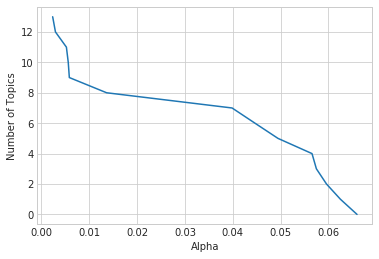

In [65]:
# Number of topics vs. alpha values
%matplotlib inline

plt.style.use('seaborn-whitegrid')

plt.plot(learned_alpha_permuted, range(len(learned_alpha_permuted)))
plt.ylabel("Number of Topics")
plt.xlabel("Alpha")

In [73]:
# Coherence
# Sources: 
# - Function: https://stackoverflow.com/questions/54924835/sagemaker-lda-topic-model-how-to-access-the-params-of-the-trained-model-also
# - Paper: http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf

def compute_coherence(betas):
    similarity_sum = 0.0
    n_combinations = 0
    for comb in combinations(betas, 2):
        similarity = cosine_similarity([comb[0]], [comb[1]])
        similarity_sum += similarity
        n_combinations += 1
    return float(similarity_sum / n_combinations)

print(compute_coherence(learned_beta_permuted))

0.227324977517128


In [117]:
# Extract results
# source: https://github.com/alex9311/alex9311.github.io/blob/master/code-projects/game-of-thrones-lda/train_lda.py

# Each row of beta is a topic and contains a probability distribution across the vocabulary
# shape: n topics * w words
topic_probabilities = learned_beta_permuted.tolist()

# get words and their weights for each topic
topic_word_weights_lst = []
for prob in topic_probabilities:
    topic_word_weights = {}
    # get word's index, its weight and look up the actual word in the topic_distribution
    for word_idx, weight in enumerate(prob):
        topic_word_weights[vocabulary[word_idx]] = weight
    topic_word_weights_lst.append(topic_word_weights)

top_words_per_topic = []
n_topics = 10
# get top 10 words for each topic
for topic_word_weights in topic_word_weights_lst:
    top_words_per_topic.append(
        sorted(topic_word_weights, key=topic_word_weights.get, reverse=True)[:n_topics]
    )
        
# print words by topic
for idx, top_words in enumerate(top_words_per_topic):
    print("Topic", idx)
    print("=====================")
    for word in top_words:
        print("{:12} {:f}".format(word, topic_word_weights_lst[idx][word]))
    print()

Topic 0
male         0.055303
unknown      0.045467
white        0.036891
black        0.027918
fail         0.024905
search       0.020433
arrest       0.019633
subject      0.018760
femal        0.017561
stop         0.016999

Topic 1
fuck         0.050148
unprofession 0.031766
rude         0.029591
arrest       0.026765
stop         0.024832
verbal       0.021253
shut         0.019589
abus         0.019436
time         0.015298
harass       0.014625

Topic 2
rude         0.037991
plant        0.003344
warrant      0.003132
indebted     0.002985
usc          0.002255
owe          0.001688
permiss      0.001577
boot         0.001384
member       0.001383
bag          0.001368

Topic 3
refus        0.054688
stop         0.038979
request      0.034363
fail         0.031828
arrest       0.031469
star         0.026444
search       0.019827
citat        0.019427
station      0.018363
file         0.017877

Topic 4
fail         0.065481
traffic      0.035748
accid        0.035170
citat     

*Inference*

In [66]:
# Deploy an inference instance
lda_inference = lda_tuner.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',  # LDA inference may work better at scale on ml.c4 instances
)
print('Endpoint name: {}'.format(lda_inference.endpoint))
# set inference data types 
lda_inference.content_type = 'text/csv'
lda_inference.serializer = csv_serializer
lda_inference.deserializer = json_deserializer

2020-06-08 03:34:28 Starting - Preparing the instances for training
2020-06-08 03:34:28 Downloading - Downloading input data
2020-06-08 03:34:28 Training - Training image download completed. Training in progress.
2020-06-08 03:34:28 Uploading - Uploading generated training model
2020-06-08 03:34:28 Completed - Training job completedDocker entrypoint called with argument(s): train
Using mxnet backend.
[06/08/2020 03:33:52 INFO 140110442735424] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'alpha0': u'1.0', u'max_restarts': u'10', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'allow_svd_init': u'true', u'epochs': u'1', u'tol': u'1e-8', u'_kvstore': u'local', u'max_iterations': u'1000'}
[06/08/2020 03:33:52 INFO 140110442735424] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'1838', u'mini_batch_size': u'17001', u'num_topics': u'14', u'alpha0': u'0.445866602

In [107]:
inference_results = []
# Make the inference in batches as sagemaker won't let us get all inferences at once
batch_size = 340
len_validation = len(validation)
n_batches = int(len_validation / batch_size)
track = 0
for i in range(n_batches):
    print("Getting batch {}".format(i))
    if len_validation - track <= 0:
        batch_results = lda_inference.predict(validation[track:])
    else:
        batch_results = lda_inference.predict(validation[track: track + 340])
    results = batch_results['predictions']
    inference_results.extend(results)
    track += 340

Getting batch 0
Getting batch 1
Getting batch 2
Getting batch 3
Getting batch 4
Getting batch 5
Getting batch 6
Getting batch 7
Getting batch 8
Getting batch 9


In [110]:
inferred_topic_mixtures_permuted = np.array([prediction['topic_mixture'] for prediction in inference_results])

print('Inferred topic mixtures (permuted):\n\n{}'.format(inferred_topic_mixtures_permuted))

Inferred topic mixtures (permuted):

[[0.86942852 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.58152896 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.36324212 0.39858484 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.13711867 0.         0.         ... 0.         0.         0.        ]]


In [111]:
inferred_topic_mixtures_permuted.shape

(3400, 14)

In [112]:
# Close inference point
sagemaker.Session().delete_endpoint(lda_inference.endpoint)

*Inference Analysis*

In [123]:
# Choose one allegation and infer topics
inferred_topic_mixtures_permuted[0]
df_idx = validation_idx[0]